Kannada PoS tagging using GRU, LSTM, BLSTM and RNN models

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from matplotlib import pyplot as plt
import codecs
import pickle
import pandas as pd
import seaborn as sns
from gensim.models import KeyedVectors
from keras.utils import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import Model
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
import codecs
import pickle

import pandas as pd
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
f = codecs.open("chandragupta.txt", "r", encoding="utf8")

raw = f.readlines()

f.close()

In [ ]:
lines = []
l = []

for w in raw:
    w = w.encode('utf-8')
    x = w.strip(b'\n').split(b' ')
    if x[0] == b'*' or x[0] == b'.' or len(x) < 2:
        if len(l) > 0:
            lines.append(l)
        l = []
        continue
    l.append((x[0], x[1]))

In [ ]:
sentences = []
labels = []
num_words = 0

for l in lines:
    s = []
    lab = []
    for w in l:
        x = w[0].decode('utf-8')
        y = w[1].decode('utf-8')
        s.append(x)
        num_words += 1
        lab.append(y)
    labels.append(lab)
    sentences.append(s)

In [ ]:
print(sentences[3])
print(labels[3])
#print(len(sentences))
#print(len(labels))


['ಇವನು', 'ಭಾರತ', 'ಉಪಖಂಡ', 'ದ', 'ಬಹುಭಾಗವನ್ನು', 'ಒಗ್ಗೂಡಿಸುವದರಲ್ಲಿ', 'ಯಶಸ್ವಿಯಾದನು']
['PRP\r', 'NN\r', 'NN\r', 'NN\r', 'NN\r', 'NN\r', 'VM\r']


In [ ]:
labels

[['NN\r',
  'NN\r',
  'SYM\r',
  'PRP\r',
  'NN\r',
  'VM\r',
  'NN\r',
  'JJ\r',
  'SYM\r',
  'VM\r',
  'NN\r',
  'NN\r',
  'NN\r'],
 ['VM\r', 'NN\r', 'NN\r', 'SYM\r', 'NN\r', 'NN\r', 'NN\r'],
 ['PRP\r', 'NN\r', 'NN\r', 'NN\r', 'VM\r'],
 ['PRP\r', 'NN\r', 'NN\r', 'NN\r', 'NN\r', 'NN\r', 'VM\r'],
 ['DEM\r',
  'NN\r',
  'NN\r',
  'NN\r',
  'NN\r',
  'VM\r',
  'QO\r',
  'NN\r',
  'CC\r',
  'NN\r',
  'QO\r',
  'JJ\r',
  'NN\r',
  'PRP\r',
  'VM\r'],
 ['NN\r',
  'NN\r',
  'VM\r',
  'NST\r',
  'NN\r',
  'NN\r',
  'NN\r',
  'QF\r',
  'QF\r',
  'NN\r',
  'VM\r'],
 ['NN\r', 'NN\r', 'NN\r', 'NN\r', 'NN\r', 'VM\r'],
 ['NN\r',
  'NN\r',
  'RB\r',
  'NN\r',
  'NN\r',
  'NN\r',
  'NN\r',
  'NN\r',
  'CC\r',
  'NN\r',
  'NN\r',
  'NN\r',
  'NN\r',
  'CC\r',
  'NN\r',
  'NN\r',
  'SYM\r',
  'NST\r',
  'NN\r',
  'NN\r',
  'CC\r',
  'NST\r',
  'NN\r',
  'NN\r',
  'NN\r',
  'NN\r',
  'NN\r',
  'NN\r',
  'VM\r'],
 ['RB\r',
  'QC\r',
  'NN\r',
  'NN\r',
  'NN\r',
  'NN\r',
  'VM\r',
  'NN\r',
  'NN\r',
  

In [ ]:
num_words = len(set([word.lower() for sentence in sentences for word in sentence]))
num_tags   = len(set([word.lower() for sentence in labels for word in sentence]))

In [ ]:
print("Total number of tagged sentences: {}".format(len(sentences)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags: {}".format(num_tags))

Total number of tagged sentences: 14965
Vocabulary size: 23044
Total number of tags: 28


In [ ]:
print('sample sentences: ', sentences[1], '\n')
print('sample labels: ', labels[1], '\n')

sample sentences:  ['ಆಳಿದ್ದು', 'ಕ್ರಿಸ್ತಪೂರ್ವ', '೩೨೦', '-', '೨೯೮', 'ರ', 'ಅವಧಿಯಲ್ಲಿ'] 

sample labels:  ['VM\r', 'NN\r', 'NN\r', 'SYM\r', 'NN\r', 'NN\r', 'NN\r'] 



In [ ]:
print("Length of first input sequence  : {}".format(len(sentences[0])))
print("Length of first output sequence : {}".format(len(labels[0])))

Length of first input sequence  : 13
Length of first output sequence : 13


In [ ]:
word_tokenizer = Tokenizer()                      # instantiate tokeniser
word_tokenizer.fit_on_texts(sentences)                    # fit tokeniser on data
sent_encoded = word_tokenizer.texts_to_sequences(sentences)  # use the tokeniser to encode input sequence

In [ ]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(labels)
lab_encoded = tag_tokenizer.texts_to_sequences(labels)

In [ ]:
different_length = [1 if len(input) != len(output) else 0 for input, output in zip(sent_encoded, lab_encoded)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

0 sentences have disparate input-output lengths.


In [ ]:
lengths = [len(seq) for seq in sent_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 118


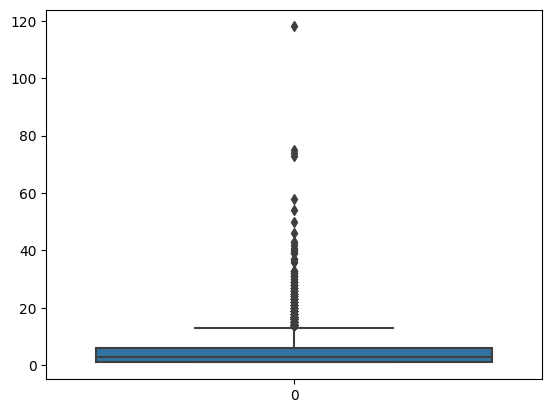

In [ ]:
sns.boxplot(lengths)
plt.show()

In [ ]:
MAX_SEQ_LENGTH = 100  # sequences greater than 100 in length will be truncated

sent_padded = pad_sequences(sent_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
lab_padded = pad_sequences(lab_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [ ]:
# print the first sequence
print(sent_padded[0], "\n"*3)
print(lab_padded[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0 6743  904   72 3629 2461 3630 6744 2462  112 1832 3631
 3632   70] 



[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 6 4 1 2 1 5 6 2 1 1 1]


In [ ]:
# assign padded sequences to X and Y
X, Y = sent_padded, lab_padded

In [ ]:
#path = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
import gensim
filename = 'GoogleNews-vectors-negative300.bin'

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://drive.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=0B7XkCwpI5KDYNlNUTTlSS21pQmM' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=0B7XkCwpI5KDYNlNUTTlSS21pQmM" -O GoogleNews-vectors-negative300.bin.gz && rm -rf /tmp/cookies.txt
!gunzip GoogleNews-vectors-negative300.bin.gz

--2023-05-19 08:26:25--  https://drive.google.com/uc?export=download&confirm=t&id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
Resolving drive.google.com (drive.google.com)... 74.125.70.113, 74.125.70.101, 74.125.70.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.70.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-8s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ipcdphsem36hjgn12ouir188jellfpsa/1684484775000/06848720943842814915/*/0B7XkCwpI5KDYNlNUTTlSS21pQmM?e=download&uuid=62c764c0-7e08-43a9-80d0-dd9057e7e435 [following]
--2023-05-19 08:26:25--  https://doc-0g-8s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ipcdphsem36hjgn12ouir188jellfpsa/1684484775000/06848720943842814915/*/0B7XkCwpI5KDYNlNUTTlSS21pQmM?e=download&uuid=62c764c0-7e08-43a9-80d0-dd9057e7e435
Resolving doc-0g-8s-docs.googleusercontent.com (doc-0g-8s-docs.googleusercontent.com)... 74.125.201.132, 2607:f8b0:4001

In [ ]:
#word2vec = KeyedVectors.load_word2vec_format(filename, binary=True)
from gensim.models.keyedvectors import KeyedVectors

#word_vectors = KeyedVectors.load_word2vec_format('https://figshare.com/ndownloader/files/10798046 -O GoogleNews-vectors-negative300.bin', binary=True)

word2vec = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
EMBEDDING_SIZE  = 300  # each word in word2vec model is represented using a 300 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index

# copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

In [ ]:
# check embedding dimension
print("Embeddings shape: {}".format(embedding_weights.shape))

Embeddings shape: (23045, 300)


In [ ]:
# use Keras' to_categorical function to one-hot encode Y
Y = to_categorical(Y)

In [ ]:
# print Y of the first output sequence
print(Y.shape)

(14965, 100, 29)


In [ ]:
# split entire data into training and testing sets
TEST_SIZE = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=4)

In [ ]:
# split training data into training and validation sets
VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=4)

In [ ]:
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (10812, 100)
Shape of output sequences: (10812, 100, 29)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (1908, 100)
Shape of output sequences: (1908, 100, 29)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (2245, 100)
Shape of output sequences: (2245, 100, 29)


In [ ]:
# total number of tags
NUM_CLASSES = Y.shape[2]
print(NUM_CLASSES)

29


LSTM Model

In [ ]:
import tensorflow as tf

# create architecture
lstm_model = Sequential()
# vocabulary size — number of unique words in data
# length of vector with which each word is represented
lstm_model.add(Embedding(input_dim = VOCABULARY_SIZE,
 output_dim = EMBEDDING_SIZE,
# length of input sequence
input_length = MAX_SEQ_LENGTH,
# word embedding matrix
weights = [embedding_weights],
# True — update embeddings_weight matrix
trainable = True
))
# add an LSTM layer which contains 64 LSTM cells
# True — return whole sequence; False — return single output of the end of the sequence
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
lstm_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
# check summary of the model
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          6913500   
                                                                 
 lstm (LSTM)                 (None, 100, 64)           93440     
                                                                 
 time_distributed (TimeDistr  (None, 100, 29)          1885      
 ibuted)                                                         
                                                                 
Total params: 7,008,825
Trainable params: 7,008,825
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#fit model
lstm_training = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
85/85 [==============================] - 28s 178ms/step - loss: 0.7019 - acc: 0.9575 - precision: 0.9565 - recall: 0.7714 - val_loss: 0.2102 - val_acc: 0.9579 - val_precision: 0.9587 - val_recall: 0.9379
Epoch 2/10
85/85 [==============================] - 11s 132ms/step - loss: 0.1501 - acc: 0.9641 - precision: 0.9733 - recall: 0.9488 - val_loss: 0.1052 - val_acc: 0.9719 - val_precision: 0.9833 - val_recall: 0.9565
Epoch 3/10
85/85 [==============================] - 5s 64ms/step - loss: 0.0811 - acc: 0.9796 - precision: 0.9905 - recall: 0.9715 - val_loss: 0.0724 - val_acc: 0.9805 - val_precision: 0.9918 - val_recall: 0.9760
Epoch 4/10
85/85 [==============================] - 8s 89ms/step - loss: 0.0617 - acc: 0.9825 - precision: 0.9924 - recall: 0.9812 - val_loss: 0.0611 - val_acc: 0.9813 - val_precision: 0.9913 - val_recall: 0.9797
Epoch 5/10
85/85 [==============================] - 4s 46ms/step - loss: 0.0529 - acc: 0.9827 - precision: 0.9937 - recall: 0.9824 - val_loss: 0

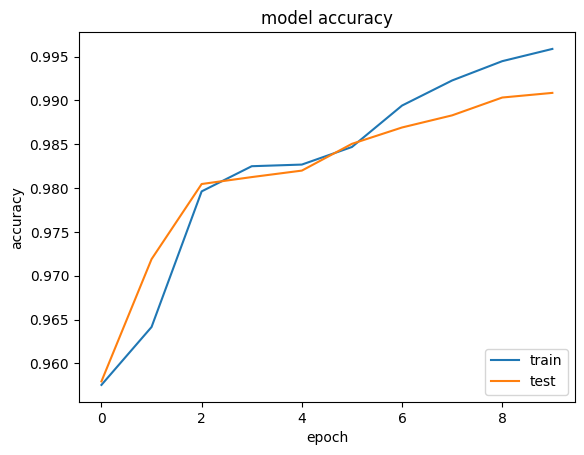

In [ ]:
 # visualise training history
plt.plot(lstm_training.history['acc'])
plt.plot(lstm_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [ ]:
lstm_loss, lstm_accuracy, lstm_precision, lstm_recall = lstm_model.evaluate(X_test, Y_test, verbose = 1)
f1_score = 2*((lstm_precision * lstm_recall)/(lstm_precision + lstm_recall))
print("Loss: {0},\nAccuracy: {1}, \nPrecision: {2}, \nRecall: {3}".format(lstm_loss, lstm_accuracy, lstm_precision, lstm_recall))
print("F1 Score: ", f1_score);

71/71 [==============================] - 1s 9ms/step - loss: 0.0346 - acc: 0.9901 - precision: 0.9931 - recall: 0.9865
Loss: 0.03463533893227577,
Accuracy: 0.9900890588760376, 
Precision: 0.9931035041809082, 
Recall: 0.9865167140960693
F1 Score:  0.989799151025609


RNN Model

In [ ]:
rnn_model = Sequential()
# create embedding layer — usually the first layer in text problems
# vocabulary size — number of unique words in data
rnn_model.add(Embedding(input_dim = VOCABULARY_SIZE,
# length of vector with which each word is represented
 output_dim = EMBEDDING_SIZE,
# length of input sequence
 input_length = MAX_SEQ_LENGTH,
# False — don’t update the embeddings
 trainable = False
))
# add an RNN layer which contains 64 RNN cells
# True — return whole sequence; False — return single output of the end of the sequence
rnn_model.add(SimpleRNN(64,
 return_sequences=True
))
# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
#compile model
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
# check summary of the model
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          6913500   
                                                                 
 simple_rnn (SimpleRNN)      (None, 100, 64)           23360     
                                                                 
 time_distributed_1 (TimeDis  (None, 100, 29)          1885      
 tributed)                                                       
                                                                 
Total params: 6,938,745
Trainable params: 25,245
Non-trainable params: 6,913,500
_________________________________________________________________


In [ ]:
#fit model
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
85/85 [==============================] - 14s 133ms/step - loss: 0.6184 - acc: 0.9233 - precision_1: 0.9601 - recall_1: 0.7837 - val_loss: 0.2019 - val_acc: 0.9588 - val_precision_1: 0.9660 - val_recall_1: 0.9479
Epoch 2/10
85/85 [==============================] - 9s 111ms/step - loss: 0.1642 - acc: 0.9659 - precision_1: 0.9765 - recall_1: 0.9484 - val_loss: 0.1339 - val_acc: 0.9721 - val_precision_1: 0.9777 - val_recall_1: 0.9556
Epoch 3/10
85/85 [==============================] - 8s 90ms/step - loss: 0.1236 - acc: 0.9735 - precision_1: 0.9792 - recall_1: 0.9582 - val_loss: 0.1086 - val_acc: 0.9769 - val_precision_1: 0.9821 - val_recall_1: 0.9706
Epoch 4/10
85/85 [==============================] - 10s 113ms/step - loss: 0.0999 - acc: 0.9766 - precision_1: 0.9802 - recall_1: 0.9727 - val_loss: 0.0913 - val_acc: 0.9769 - val_precision_1: 0.9798 - val_recall_1: 0.9734
Epoch 5/10
85/85 [==============================] - 9s 109ms/step - loss: 0.0866 - acc: 0.9766 - precision_1: 0

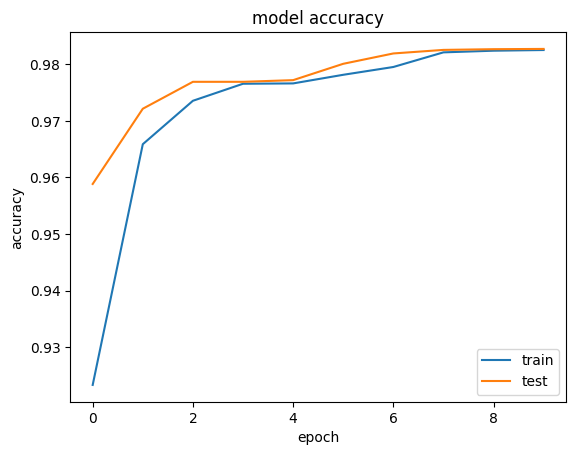

In [ ]:
 # visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [ ]:
# rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test, Y_test, verbose = 1)
# print("Loss: {0},\nAccuracy: {1}".format(rnn_loss, rnn_accuracy))
rnn_loss, rnn_accuracy, rnn_precision, rnn_recall = rnn_model.evaluate(X_test, Y_test, verbose = 1)
rnn_f1_score = 2*((rnn_precision * rnn_recall)/(rnn_precision + rnn_recall))
print("Loss: {0},\nAccuracy: {1}, \nPrecision: {2}, \nRecall: {3}".format(rnn_loss, rnn_accuracy, rnn_precision, rnn_recall))
print("F1 Score: ", rnn_f1_score);

71/71 [==============================] - 1s 11ms/step - loss: 0.0680 - acc: 0.9820 - precision_1: 0.9859 - recall_1: 0.9780
Loss: 0.06804899126291275,
Accuracy: 0.9819599390029907, 
Precision: 0.9859316945075989, 
Recall: 0.9780222773551941
F1 Score:  0.9819610591631048


Bi-DIRECTIONAL LSTM Model

In [ ]:
bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim = VOCABULARY_SIZE,
 output_dim = EMBEDDING_SIZE,
 input_length = MAX_SEQ_LENGTH,
 weights = [embedding_weights],
 trainable = True
))
bidirect_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
#compile model
bidirect_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
# check summary of model
bidirect_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          6913500   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         186880    
 l)                                                              
                                                                 
 time_distributed_2 (TimeDis  (None, 100, 29)          3741      
 tributed)                                                       
                                                                 
Total params: 7,104,121
Trainable params: 7,104,121
Non-trainable params: 0
_________________________________________________________________


In [ ]:
bidirect_training = bidirect_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
85/85 [==============================] - 18s 171ms/step - loss: 0.5410 - acc: 0.9598 - precision_2: 0.9783 - recall_2: 0.8060 - val_loss: 0.0947 - val_acc: 0.9776 - val_precision_2: 0.9987 - val_recall_2: 0.9581
Epoch 2/10
85/85 [==============================] - 11s 123ms/step - loss: 0.0849 - acc: 0.9797 - precision_2: 0.9973 - recall_2: 0.9626 - val_loss: 0.0787 - val_acc: 0.9814 - val_precision_2: 0.9972 - val_recall_2: 0.9656
Epoch 3/10
85/85 [==============================] - 5s 60ms/step - loss: 0.0701 - acc: 0.9820 - precision_2: 0.9966 - recall_2: 0.9719 - val_loss: 0.0705 - val_acc: 0.9817 - val_precision_2: 0.9968 - val_recall_2: 0.9723
Epoch 4/10
85/85 [==============================] - 4s 48ms/step - loss: 0.0587 - acc: 0.9830 - precision_2: 0.9974 - recall_2: 0.9777 - val_loss: 0.0606 - val_acc: 0.9834 - val_precision_2: 0.9973 - val_recall_2: 0.9746
Epoch 5/10
85/85 [==============================] - 4s 47ms/step - loss: 0.0460 - acc: 0.9872 - precision_2: 0.9

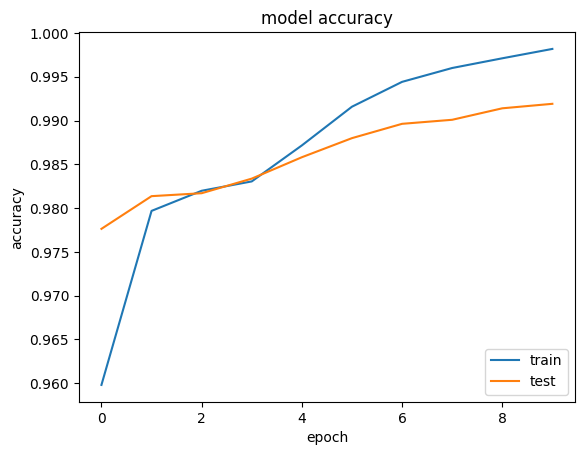

In [ ]:
 # visualise training history
plt.plot(bidirect_training.history['acc'])
plt.plot(bidirect_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [ ]:
# blstm_loss, blstm_accuracy = bidirect_model.evaluate(X_test, Y_test, verbose = 1)
# print("Loss: {0},\nAccuracy: {1}".format(blstm_loss, blstm_accuracy))
blstm_loss, blstm_accuracy, blstm_precision, blstm_recall = bidirect_model.evaluate(X_test, Y_test, verbose = 1)
blstm_f1_score = 2*((blstm_precision * blstm_recall)/(blstm_precision + blstm_recall))
print("Loss: {0},\nAccuracy: {1}, \nPrecision: {2}, \nRecall: {3}".format(blstm_loss, blstm_accuracy, blstm_precision, blstm_recall))
print("F1 Score: ", blstm_f1_score);

71/71 [==============================] - 1s 8ms/step - loss: 0.0261 - acc: 0.9917 - precision_2: 0.9957 - recall_2: 0.9891
Loss: 0.026147210970520973,
Accuracy: 0.9917283058166504, 
Precision: 0.9956506490707397, 
Recall: 0.9890913367271423
F1 Score:  0.9923601540647932


GRU Model

In [ ]:
gru_model = Sequential()
gru_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                        output_dim    = EMBEDDING_SIZE,
                        input_length  = MAX_SEQ_LENGTH,
                        weights       = [embedding_weights],
                        trainable     = True
))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
#compile model
gru_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
#model summary
gru_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 300)          6913500   
                                                                 
 gru (GRU)                   (None, 100, 64)           70272     
                                                                 
 time_distributed_3 (TimeDis  (None, 100, 29)          1885      
 tributed)                                                       
                                                                 
Total params: 6,985,657
Trainable params: 6,985,657
Non-trainable params: 0
_________________________________________________________________


In [ ]:
gru_training = gru_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
85/85 [==============================] - 16s 158ms/step - loss: 0.7523 - acc: 0.9613 - precision_3: 0.9766 - recall_3: 0.7323 - val_loss: 0.1236 - val_acc: 0.9708 - val_precision_3: 0.9906 - val_recall_3: 0.9609
Epoch 2/10
85/85 [==============================] - 7s 84ms/step - loss: 0.0945 - acc: 0.9767 - precision_3: 0.9892 - recall_3: 0.9680 - val_loss: 0.0768 - val_acc: 0.9795 - val_precision_3: 0.9879 - val_recall_3: 0.9730
Epoch 3/10
85/85 [==============================] - 6s 67ms/step - loss: 0.0635 - acc: 0.9822 - precision_3: 0.9911 - recall_3: 0.9774 - val_loss: 0.0599 - val_acc: 0.9816 - val_precision_3: 0.9930 - val_recall_3: 0.9760
Epoch 4/10
85/85 [==============================] - 4s 50ms/step - loss: 0.0486 - acc: 0.9853 - precision_3: 0.9953 - recall_3: 0.9822 - val_loss: 0.0484 - val_acc: 0.9852 - val_precision_3: 0.9949 - val_recall_3: 0.9793
Epoch 5/10
85/85 [==============================] - 5s 55ms/step - loss: 0.0349 - acc: 0.9911 - precision_3: 0.997

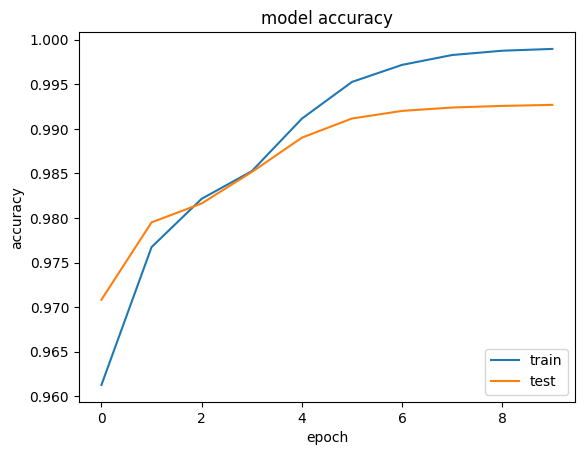

In [ ]:

# visualise training history
plt.plot(gru_training.history['acc'])
plt.plot(gru_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()


In [ ]:
#gru_loss, gru_accuracy = gru_model.evaluate(X_test, Y_test, verbose = 1)
# print("Loss: {0},\nAccuracy: {1}".format(gru_loss, gru_accuracy))
gru_loss, gru_accuracy, gru_precision, gru_recall = gru_model.evaluate(X_test, Y_test, verbose = 1)
gru_f1_score = 2*((gru_precision * gru_recall)/(gru_precision + gru_recall))
print("Loss: {0},\nAccuracy: {1}, \nPrecision: {2}, \nRecall: {3}".format(gru_loss, gru_accuracy, gru_precision, gru_recall))
print("F1 Score: ", gru_f1_score);

71/71 [==============================] - 0s 5ms/step - loss: 0.0247 - acc: 0.9923 - precision_3: 0.9933 - recall_3: 0.9916
Loss: 0.02474777214229107,
Accuracy: 0.9923028945922852, 
Precision: 0.9932845830917358, 
Recall: 0.9915634989738464
F1 Score:  0.9924232948470836


In [ ]:
max_accuracy = max(lstm_accuracy, rnn_accuracy, blstm_accuracy, gru_accuracy)

In [ ]:
print('Maximum Accuracy achieved is ', max_accuracy)

Maximum Accuracy achieved is  0.9923028945922852
